In [211]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import ast  
import matplotlib.patches as mpatches
import numpy as np

#path = "/Users/claireconzelmann/Documents/KIHC-affordable-housing-analysis"
path = "/Users/aliso/OneDrive/Documents/KIHC-affordable-housing-analysis"

In [212]:
tif_districts = pd.read_csv(os.path.join(path, "Data/Raw/Boundaries_Tax_Increment_Financing_Districts.csv"))
city_land = pd.read_csv(os.path.join(path, "Data/Raw/City-Owned_Land_Inventory_20250320.csv"))
l_stops = pd.read_csv(os.path.join(path, "Data/Raw/CTA_System_Information_List_of_L_Stops.csv"))
vacant_buildings = pd.read_csv(os.path.join(path, "Data/Raw/311_Service_Requests_20250330.csv"))
neighborhoods = pd.read_csv(os.path.join(path, "Data/Raw/Neighborhoods.csv"))
sale_buildings = pd.read_csv(os.path.join(path, "Data/Raw/Crexi_Building_Data.csv"))
bus_stops_gdf = gpd.read_file(os.path.join(path, "Data/Raw/bus_routes.shp"))
metra_stops_gdf = gpd.read_file(os.path.join(path, "Data/Raw/MetraStations.shp"))

In [3]:
#create geopandas objects
tif_districts["the_geom"] = tif_districts["the_geom"].apply(wkt.loads)
tif_districts_gdf = gpd.GeoDataFrame(tif_districts, geometry="the_geom")
tif_districts_gdf = tif_districts_gdf.set_crs(epsg=4326, inplace=True)

city_land_gpd = gpd.GeoDataFrame(city_land, 
                                 geometry=gpd.points_from_xy(city_land.Longitude, 
                                                             city_land.Latitude), 
                                 crs="EPSG:4326")

# Convert string representation of tuples of long/lat in lstop data into actual tuples
l_stops["Location"] = l_stops["Location"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

l_stops["geometry"] = l_stops["Location"].apply(lambda x: Point(x[1], x[0]))
l_stops_gdf = gpd.GeoDataFrame(l_stops, geometry="geometry")
l_stops_gdf.set_crs(epsg=4326, inplace=True)

bus_stops_gdf.set_crs(epsg=4326, inplace=True)
metra_stops_gdf.to_crs(epsg=4326, inplace=True)


In [12]:
#filtering metra stops to chicago only
metra_stops_gdf = metra_stops_gdf.loc[metra_stops_gdf["MUNICIPALI"]=="Chicago"]

#create 1/2 mile buffers around CTA and Metra stops (ETOD eligible)
metra_stops_gdf = metra_stops_gdf.to_crs(epsg=3857)
metra_stops_gdf["buffer_half_mile"] = metra_stops_gdf.geometry.buffer(804.67)
metra_stops_gdf = metra_stops_gdf.to_crs(epsg=4326)

l_stops_gdf = l_stops_gdf.to_crs(epsg=3857)
l_stops_gdf["buffer_half_mile"] = l_stops_gdf.geometry.buffer(804.67)
l_stops_gdf = l_stops_gdf.to_crs(epsg=4326)

In [13]:
#find vacant city owned lots within 1/2 buffers of transit stations
etod_lots_l = gpd.sjoin(city_land_gpd, 
                        l_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326), 
                        predicate="within")

etod_lots_metra = gpd.sjoin(city_land_gpd, 
                        metra_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326), 
                        predicate="within")

etod_lots = pd.concat([etod_lots_l, etod_lots_metra], ignore_index=True).drop_duplicates(subset=["ID"])
etod_lots = etod_lots.drop("index_right", axis=1)


In [14]:
#find etod eligible lots that are within existing TIFs
etod_lots_tifs = gpd.sjoin(etod_lots, 
                        tif_districts_gdf, 
                        predicate="within")
etod_lots_tifs = etod_lots_tifs.drop_duplicates(subset=["ID"])

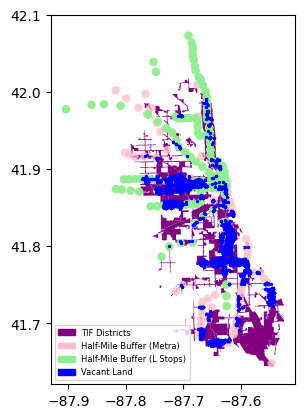

In [ ]:
#plot everything together
fig, ax = plt.subplots()
tif_districts_gdf.plot(ax=ax, 
                       color='purple',
                       label="TIF districts")
metra_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326).plot(ax=ax, 
                                                                        color="pink", 
                                                                        alpha=0.8, 
                                                                        label="Half-Mile Buffer")
l_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326).plot(ax=ax, 
                                                                    color="lightgreen", 
                                                                    alpha=0.8, 
                                                                    label="Half-Mile Buffer")
etod_lots_tifs.plot(ax=ax, 
                    color='blue', 
                    markersize=2,
                    label="vacant land")

legend_patches = [
    mpatches.Patch(color='purple', label="TIF Districts"),
    mpatches.Patch(color='pink', label="Half-Mile Buffer (Metra)"),
    mpatches.Patch(color='lightgreen', label="Half-Mile Buffer (L Stops)"),
    mpatches.Patch(color='blue', label="Vacant Land")
]

ax.legend(handles=legend_patches, loc="lower left", fontsize=6)

In [ ]:
#Creating GDF of neighborhood boundaries in Chicago
neighborhoods["geometry"] = neighborhoods["the_geom"].apply(wkt.loads)
neighborhood_gdf = gpd.GeoDataFrame(neighborhoods, geometry="geometry")
neighborhood_gdf = neighborhood_gdf.set_crs("EPSG:4326", inplace=True)

#Reading assessed home values data
merged_folder = 'Data/merged_gdf_shapefile'
merged_path = os.path.join(path, merged_folder,
 'merged_gdf_shapefile.shp')
merged_gdf = gpd.read_file(merged_path)


#Finding average home values by neighborhood for each Chicago neighborhood
merged_gdf['certified_tot_mean'] = pd.to_numeric(merged_gdf['certifie_1'], errors='coerce').fillna(0)
asessor_2000 = merged_gdf[merged_gdf["year"] == 2000].groupby("pri_neigh")["certified_tot_mean"].mean().reset_index()
asessor_2000 = asessor_2000.rename(columns={"certified_tot_mean": "value_2000"})
    
assessor_2023 = merged_gdf[merged_gdf["year"] == 2023].groupby("pri_neigh")["certified_tot_mean"].mean().reset_index()
assessor_2023 = assessor_2023.rename(columns={"certified_tot_mean": "value_2023"})

#Merging together and creating a difference column
av_merged = pd.merge(asessor_2000, assessor_2023, on="pri_neigh", how="inner")
av_merged["difference"] = abs(av_merged["value_2023"] - av_merged["value_2000"])
av_merged["percent_change"] = av_merged["difference"] / abs(av_merged["value_2000"])
av_merged = av_merged.rename(columns={'pri_neigh': 'PRI_NEIGH'})

#Merging with neighborhood GDF
merged_neighborhoods = pd.merge(av_merged, neighborhood_gdf, on='PRI_NEIGH', how='left')
merged_neighborhoods_gdf = gpd.GeoDataFrame(merged_neighborhoods, geometry='geometry')
merged_neighborhoods_gdf.set_crs('EPSG:4326', allow_override=True, inplace=True)

Index(['PRI_NEIGH', 'value_2000', 'value_2023', 'difference', 'percent_change',
       'the_geom', 'SEC_NEIGH', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry'],
      dtype='object')


In [177]:
#Adding parcel addresss and square foot data 
addresses = pd.read_csv(os.path.join(path, "Data/Raw/Assessor_-_Parcel_Addresses_20250403.csv"))
print(addresses['pin'].value_counts())
print(len(addresses))
sqft = pd.read_csv(os.path.join(path, "Data/Raw/Assessor_-_Single_and_Multi-Family_Improvement_Characteristics_20250403.csv"))
sqft=sqft.groupby("pin")["building_sqft"].sum().reset_index()
print(sqft['pin'].value_counts())
print(len(sqft))

addresses_sqft = pd.merge(addresses, sqft, on='pin', how='inner')
print(len(addresses_sqft))
addresses_sqft = addresses_sqft.rename(columns={'property_address': 'Address'})


pin
1011230380000     1
13202240120000    1
13202250010000    1
13202240380000    1
13202240370000    1
                 ..
9253240090000     1
9253240080000     1
9253240070000     1
9253240060000     1
16094140090000    1
Name: count, Length: 1864107, dtype: int64
1864107


C:\Users\aliso\AppData\Local\Temp\ipykernel_19868\2920527460.py:5: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  sqft = pd.read_csv(os.path.join(path, "Data/Raw/Assessor_-_Single_and_Multi-Family_Improvement_Characteristics_20250403.csv"))


pin
1011000040000     1
20113030050000    1
20113000240000    1
20113000250000    1
20113010020000    1
                 ..
13174210230000    1
13174210240000    1
13174210250000    1
13174210260000    1
33323020150000    1
Name: count, Length: 1094484, dtype: int64
1094484
1094481


In [213]:

#Cleaning CREXI dataset 
#Dropping NAs
sale_buildings = sale_buildings.dropna(subset=['Latitude'])
sale_buildings = sale_buildings.dropna(subset=['Longitude'])

#Filtering
sale_buildings = sale_buildings.loc[sale_buildings["Purchase Entire Building?"]=="Y"]


#merging with square foot data
sale_buildings['Address'] = sale_buildings['Address'].str.upper()

sale_buildings = pd.merge(sale_buildings, addresses_sqft, on='Address', how='left')

sale_buildings.to_csv('C:/Users/aliso/OneDrive/Documents/sale_buildings_neighborhood.csv')

#Creating buildings for sales GDF
sale_buildings_gdf = gpd.GeoDataFrame(sale_buildings, 
                                 geometry=gpd.points_from_xy(sale_buildings.Longitude, 
                                                             sale_buildings.Latitude), 
                                 crs="EPSG:4326")



#Merging with neighborhood boundaries 
sale_buildings_neighborhood_gdf = gpd.sjoin(sale_buildings_gdf, merged_neighborhoods_gdf,
                             how='inner', predicate='intersects')

sale_buildings.to_csv('C:/Users/aliso/OneDrive/Documents/sale_buildings_neighborhood.csv')

In [214]:
#Loading full vacant dataset 
vacant_buildings = vacant_buildings.loc[vacant_buildings["DUPLICATE"]==False]
vacant_buildings = vacant_buildings.rename(columns={'STREET_ADDRESS': 'Address'})

#merging with address data
vacant_buildings['Address'] = vacant_buildings['Address'].str.upper()
vacant_buildings = pd.merge(vacant_buildings, addresses_sqft, on='Address', how='left')

#vacant_buildings.to_csv('C:/Users/aliso/OneDrive/Documents/vacant_buildings_neighborhood.csv')

vacant_buildings_gdf = gpd.GeoDataFrame(vacant_buildings, geometry=gpd.points_from_xy(vacant_buildings.LONGITUDE, vacant_buildings.LATITUDE), crs="EPSG:4326")
vacant_buildings_gdf.rename(columns={'building_sqft': 'SqFt'}, inplace=True)
vacant_buildings_neighborhood_gdf = gpd.sjoin(vacant_buildings_gdf, merged_neighborhoods_gdf,
                             how='inner', predicate='intersects')

In [215]:
#Loading zone data and filtering out zones from sales and vacant building data
zones = pd.read_csv(os.path.join(path, "Data/Raw/Boundaries_-_Zoning_Districts__current__20250404.csv"))
zones['geometry'] = zones['the_geom'].apply(wkt.loads)
zones_gdf = gpd.GeoDataFrame(zones, geometry="geometry")
zones_gdf.set_crs('EPSG:4326', allow_override=True, inplace=True)


sale_buildings_neighborhood_gdf = gpd.sjoin(sale_buildings_neighborhood_gdf, zones_gdf,
                             how='left', predicate='within',  lsuffix='_left', rsuffix='_right')


vacant_buildings_neighborhood_gdf = gpd.sjoin(vacant_buildings_neighborhood_gdf, zones_gdf, 
                             how='left', predicate='within', lsuffix='_left', rsuffix='_right')




In [217]:

#remove zones that cannot have residential units built
removelist = ["C3", "DS", "M1", "M2", "M3", "PMD", "POS"]
sale_buildings_neighborhood_gdf["flagCol"] = np.where(
    sale_buildings_neighborhood_gdf["ZONE_CLASS"].str.contains('|'.join(removelist)),1,0)
sale_buildings_neighborhood_gdf = sale_buildings_neighborhood_gdf.loc[sale_buildings_neighborhood_gdf["flagCol"] != 1]
sale_buildings_neighborhood_gdf = sale_buildings_neighborhood_gdf.drop(["flagCol"], axis=1)

vacant_buildings_neighborhood_gdf["flagCol"] = np.where(
    vacant_buildings_neighborhood_gdf["ZONE_CLASS"].str.contains('|'.join(removelist)),1,0)
vacant_buildings_neighborhood_gdf = vacant_buildings_neighborhood_gdf.loc[vacant_buildings_neighborhood_gdf["flagCol"] != 1]
vacant_buildings_neighborhood_gdf = vacant_buildings_neighborhood_gdf.drop(["flagCol"], axis=1)

#create flag for single family zones
sale_buildings_neighborhood_gdf["sfh_flag"] = np.where(sale_buildings_neighborhood_gdf["ZONE_CLASS"].str.contains("RS-"), 1, 0)
vacant_buildings_neighborhood_gdf["sfh_flag"] = np.where(vacant_buildings_neighborhood_gdf["ZONE_CLASS"].str.contains("RS-"), 1, 0)

#create broader category for zones
zone_cats = {"B-Business":"B", 
             "C-Commercial":"C",
             "D-Downtown": "D",
             "PD-Planned Development":"PD",
             "R-Residential":"R"}

def map_category(item):
    for key, value in zone_cats.items():
        if item.startswith(value):  # Check if item starts with dictionary value
            return key
    return "Unknown"  # Default value if no match is found

sale_buildings_neighborhood_gdf["ZONE_CAT"] = sale_buildings_neighborhood_gdf["ZONE_CLASS"].apply(map_category)
vacant_buildings_neighborhood_gdf["ZONE_CAT"] = vacant_buildings_neighborhood_gdf["ZONE_CLASS"].apply(map_category)


In [ ]:
#List of neighborhoods in the loop and north side 
#neigh_list = ['Lake View', 'Wrigleyville', 'Boystown', 'Lincoln Park', 'North Center', 
              #'Sheffield & DePaul', 'Old Town', 'Gold Coast', 'River North', 'Grant Park', 
              #'Millenium Park', 'Streeterville', 'Magnificent Mile', 'Loop', 'Rush & Division',
              #'Near South Side', 'Museum Campus', 'Printers Row', 'West Loop', 'Wicker Park', 'Bucktown',
              #'Edgewater', 'Uptown', 'Greektown', 'Ukrainian Village', 'West Town', 'North Center', 'East Village',
              #'Andersonville', 'Little Italy, UIC', 'United Center']
#subsetting neighborhood gdf
#subset_merged_neighborhoods_gdf = merged_neighborhoods_gdf[merged_neighborhoods_gdf['PRI_NEIGH'].isin(neigh_list)]

#subset_sale_buildings_neighborhood_gdf = gpd.sjoin(sale_buildings_gdf, subset_merged_neighborhoods_gdf,
                             #how='inner', predicate='intersects')

0     PD 971
1     PD 971
2      DC-16
3      DX-12
4       M1-2
       ...  
84      DX-7
85      DX-5
86      M1-3
87      DS-3
88    PMD 11
Name: ZONE_CLASS, Length: 89, dtype: object


In [165]:
#creating and saving dataset for vacant data
subset_vacant_buildings_neighborhood_gdf = gpd.sjoin(vacant_buildings_gdf, subset_merged_neighborhoods_gdf,
                             how='inner', predicate='intersects')

subset_vacant_buildings_neighborhood = pd.DataFrame(subset_vacant_buildings_neighborhood_gdf)
#subset_vacant_buildings_neighborhood.to_csv('C:/Users/aliso/OneDrive/Documents/subset_vacant_buildings_neighborhood.csv')


In [225]:
sale_buildings_neighborhood_gdf_sqft = sale_buildings_neighborhood_gdf[['PRI_NEIGH', 'SqFt']]
vacant_buildings_neighborhood_gdf_sqft = vacant_buildings_neighborhood_gdf[['PRI_NEIGH', 'SqFt']]
sqft_neighborhoods = pd.concat([sale_buildings_neighborhood_gdf_sqft, vacant_buildings_neighborhood_gdf_sqft])
sqft_neighborhoods['SqFt'] = pd.to_numeric(sqft_neighborhoods['SqFt'], errors='coerce')
total_sqft_neighborhoods = sqft_neighborhoods.groupby('PRI_NEIGH')['SqFt'].sum()
print(total_sqft_neighborhoods)
merged_neighborhoods_gdf = merged_neighborhoods_gdf.merge(total_sqft_neighborhoods, on='PRI_NEIGH', how='left')
merged_neighborhoods_gdf.head()

PRI_NEIGH
Albany Park        4030.0
Andersonville         0.0
Archer Heights     1520.0
Ashburn            5535.0
Auburn Gresham    51068.0
                   ...   
West Ridge        43065.0
West Town         20478.0
Wicker Park       21857.0
Woodlawn           5619.0
Wrigleyville       4686.0
Name: SqFt, Length: 75, dtype: float64


,PRI_NEIGH,value_2000,value_2023,difference,percent_change,the_geom,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,SqFt_x,SqFt_y
0,Albany Park,27257.934086,44079.753929,16821.819843,0.617135,MULTIPOLYGON (((-87.70403771340104 41.97355158...,"NORTH PARK,ALBANY PARK",5.354223e+07,39339.016439,"MULTIPOLYGON (((-87.70404 41.97355, -87.70403 ...",4030.0,4030.0
1,Andersonville,39393.917787,64336.860571,24942.942784,0.633167,MULTIPOLYGON (((-87.66114249176968 41.97630327...,ANDERSONVILLE,9.584593e+06,12534.092625,"MULTIPOLYGON (((-87.66114 41.9763, -87.66132 4...",0.0,0.0
2,Archer Heights,21336.648632,34310.842635,12974.194003,0.608071,MULTIPOLYGON (((-87.7143693473594 41.826040563...,"ARCHER HEIGHTS,WEST ELSDON",5.592251e+07,31880.021030,"MULTIPOLYGON (((-87.71437 41.82604, -87.71436 ...",1520.0,1520.0
3,Armour Square,15895.849394,33220.139575,17324.290181,1.089863,MULTIPOLYGON (((-87.62920071904188 41.84712706...,"ARMOUR SQUARE,CHINATOWN",1.714147e+07,24359.189625,"MULTIPOLYGON (((-87.6292 41.84713, -87.62919 4...",NaN,NaN
4,Ashburn,17288.182552,23707.719067,6419.536515,0.371325,MULTIPOLYGON (((-87.71254775561138 41.75733733...,ASHBURN,1.354603e+08,54818.154632,"MULTIPOLYGON (((-87.71255 41.75734, -87.71252 ...",5535.0,5535.0


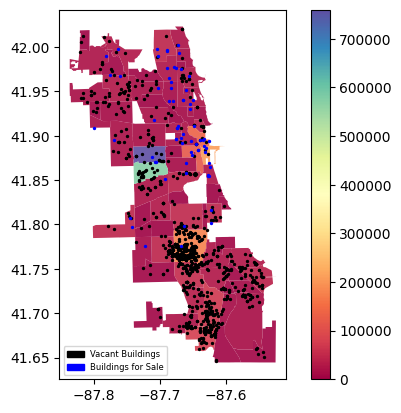

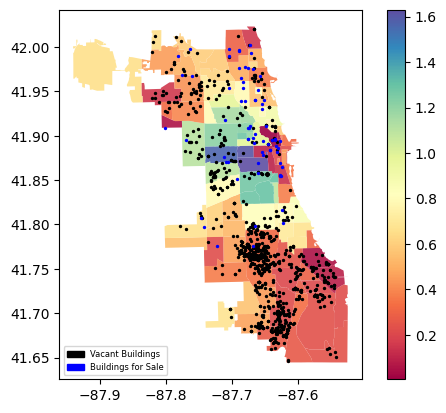

In [229]:
#Chicago map by total sqft available
fig, ax = plt.subplots()
merged_neighborhoods_gdf.plot(ax=ax, column="SqFt_x", cmap='Spectral', legend=True, alpha=0.9)
vacant_buildings_neighborhood_gdf.plot(ax=ax, 
                          color='black', 
                          markersize=2,
                          label="Vacant Buildings")
sale_buildings_neighborhood_gdf.plot(ax=ax, 
                          color='blue', 
                          markersize=2,
                          label="Buildings for Sale")
legend = [
    mpatches.Patch(color='black', label="Vacant Buildings"),
    mpatches.Patch(color='blue', label="Buildings for Sale")]

ax.legend(handles=legend, loc="lower left", fontsize=6)

#Chicago map by gentrification
fig, ax = plt.subplots()
merged_neighborhoods_gdf.plot(ax=ax, column="percent_change", cmap='Spectral', legend=True, alpha=0.9)
vacant_buildings_neighborhood_gdf.plot(ax=ax, 
                          color='black', 
                          markersize=2,
                          label="Vacant Buildings")
sale_buildings_neighborhood_gdf.plot(ax=ax, 
                          color='blue', 
                          markersize=2,
                          label="Buildings for Sale")
legend = [
    mpatches.Patch(color='black', label="Vacant Buildings"),
    mpatches.Patch(color='blue', label="Buildings for Sale")]

ax.legend(handles=legend, loc="lower left", fontsize=6)

31    1.567246
Name: percent_change, dtype: float64
31    759747.0
Name: SqFt_x, dtype: float64
2
13
53    1.271515
Name: percent_change, dtype: float64
53    38297.0
Name: SqFt_x, dtype: float64
1
14


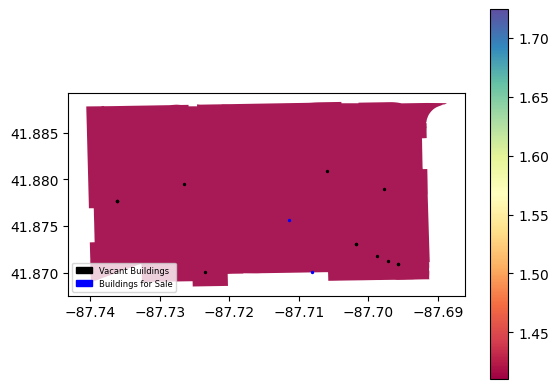

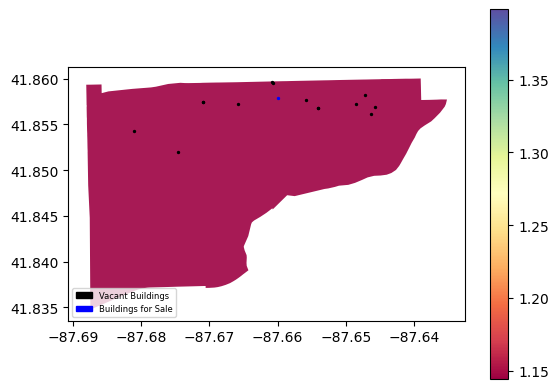

In [236]:

#plotting some options for subsetted maps 
#Garfield park
# Percent change
garfield_park = merged_neighborhoods_gdf[merged_neighborhoods_gdf['PRI_NEIGH'] == 'Garfield Park']
print(garfield_park['percent_change'])
# Total sqft available
print(garfield_park['SqFt_x'])
#number of buildings for sale:
garfield_park_sale = sale_buildings_neighborhood_gdf[sale_buildings_neighborhood_gdf['PRI_NEIGH'] == 'Garfield Park']
print(len(garfield_park_sale))
#number of vacant buildings:
garfield_park_vacant = vacant_buildings_neighborhood_gdf[vacant_buildings_neighborhood_gdf['PRI_NEIGH'] == 'Garfield Park']
print(len(garfield_park_vacant))

fig, ax = plt.subplots()
garfield_park.plot(ax=ax, column="percent_change", cmap='Spectral', legend=True, alpha=0.9)
garfield_park_vacant.plot(ax=ax, 
                          color='black', 
                          markersize=2,
                          label="Vacant Buildings")
garfield_park_sale.plot(ax=ax, 
                          color='blue', 
                          markersize=2,
                          label="Buildings for Sale")
legend = [
    mpatches.Patch(color='black', label="Vacant Buildings"),
    mpatches.Patch(color='blue', label="Buildings for Sale")]

ax.legend(handles=legend, loc="lower left", fontsize=6)


#Lower westside 
# Percent change
lower_westside = merged_neighborhoods_gdf[merged_neighborhoods_gdf['PRI_NEIGH'] == 'Lower West Side']
print(lower_westside['percent_change'])
# Total sqft available
print(lower_westside['SqFt_x'])
#number of buildings for sale:
lower_westside_sale = sale_buildings_neighborhood_gdf[sale_buildings_neighborhood_gdf['PRI_NEIGH'] == 'Lower West Side']
print(len(lower_westside_sale))
#number of vacant buildings:
lower_westside_vacant = vacant_buildings_neighborhood_gdf[vacant_buildings_neighborhood_gdf['PRI_NEIGH'] == 'Lower West Side']
print(len(lower_westside_vacant))

fig, ax = plt.subplots()
lower_westside.plot(ax=ax, column="percent_change", cmap='Spectral', legend=True, alpha=0.9)
lower_westside_vacant.plot(ax=ax, 
                          color='black', 
                          markersize=2,
                          label="Vacant Buildings")
lower_westside_sale.plot(ax=ax, 
                          color='blue', 
                          markersize=2,
                          label="Buildings for Sale")
legend = [
    mpatches.Patch(color='black', label="Vacant Buildings"),
    mpatches.Patch(color='blue', label="Buildings for Sale")]

ax.legend(handles=legend, loc="lower left", fontsize=6)

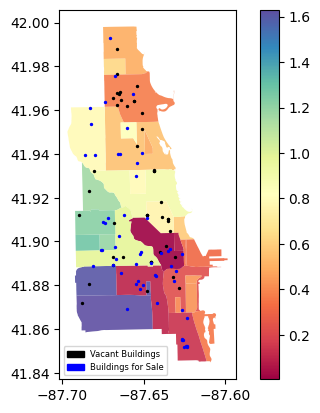

In [ ]:
#printing subsetted map
#fig, ax = plt.subplots()
#subset_merged_neighborhoods_gdf.plot(ax=ax, column="percent_change", cmap='Spectral', alpha=0.9, legend=True)
#subset_vacant_buildings_neighborhood_gdf.plot(ax=ax, 
                          color='black', 
                          markersize=2,
                          label="Vacant Buildings")
#subset_sale_buildings_neighborhood_gdf.plot(ax=ax, 
                          color='blue', 
                          markersize=2,
                          label="Buildings for Sale")
#legend = [
    #mpatches.Patch(color='black', label="Vacant Buildings"),
    #mpatches.Patch(color='blue', label="Buildings for Sale")]

#ax.legend(handles=legend, loc="lower left", fontsize=6)

In [ ]:
#OLD CODE

#filtering vacant buildings to within the past year
#vacant_buildings = vacant_buildings.loc[vacant_buildings["DUPLICATE"]==False]
#start_date = '2024-10-21'
#end_date = '2025-03-21'
#vacant_buildings['CREATED_DATE'] = pd.to_datetime(vacant_buildings['CREATED_DATE'], format='%m/%d/%Y %I:%M:%S %p')
#vacant_buildings_recent = vacant_buildings[(vacant_buildings['CREATED_DATE'] >= start_date) & (vacant_buildings['CREATED_DATE'] <= end_date)]

#vacant_buildings_recent_gdf = gpd.GeoDataFrame(vacant_buildings_recent, 
# geometry=gpd.points_from_xy(vacant_buildings_recent.LONGITUDE, vacant_buildings_recent.LATITUDE), crs="EPSG:4326")


#fig, ax = plt.subplots()
#vacant_buildings_recent_gdf.plot(ax=ax, 
                    #color='blue', 
                   # markersize=2,
                    #label="vacant buildings")